# Урок 4. Тематическое моделирование. EM-алгоритм
Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

рабочие ссылки с твитами
https://disk.yandex.ru/i/v5HM-ENiGXZVpQ
https://disk.yandex.ru/i/koR5eMCToCZS2Q

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

## Data preparation

In [77]:
# will be used only questions or questions + answers
plus_answers = False

### Data downloading

In [2]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
def topic_from_ids(soup):
    return [i.getText() for i  in soup.findAll('p', {'class':'appeal-cat-title'})]
def author_from_ids(soup):
    final_list = [i.find(text=True, recursive=False).strip() for i  in soup.findAll('p', {'class':'appeal-element-bottom'})]
    return final_list[1::3]
def doc_name_from_ids(soup):
    return [i.text.strip() for i  in soup.findAll('span', {'class':'custom-underline'})]

pages_number = 150
urls = []
topic = []
author = []
doc = []
for page in tqdm(range(1, pages_number), desc='Pages'):
    time.sleep(0.3)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))
    topic.extend(topic_from_ids(soup))
    author.extend(author_from_ids(soup))
    doc.extend(doc_name_from_ids(soup))

Pages:   0%|          | 0/149 [00:00<?, ?it/s]

In [4]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.3)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/745 [00:00<?, ?it/s]

In [5]:
## посмотрим, что скачалось
N = 1
print('Q:', question[N])
print()
print('A:', answers[N])

Q: Здравствуйте. Соседи по участку в СНТ 
 держат коз и кур, законно ли это?

A: Здравствуйте Алёна.
Раздел «Виртуальная приемная» ГИС ЗПП представляет собой площадку для общения между Роспотребнадзором и потребителями по вопросам защиты их прав. Ваш вопрос не попадает под действие Закона РФ «О защите прав потребителей» и не может быть рассмотрен в данном разделе. 



In [73]:
if plus_answers:
  d = {'Doc': doc, 'author': author, 'topic': topic, 'question': question, 'answer': answers}
else:
  d = {'Doc': doc, 'author': author, 'topic': topic, 'question': question}

data = pd.DataFrame(data = d)
d=None


In [74]:
data.head()

Doc    author  \
0                                           Жалоба     Антон   
1                                              СНТ     Алёна   
2       Отказ в гарантийном ремонте в магазине DNS   Надежда   
3        Не возвращают деньги за бракованный товар  Светлана   
4  Невозврат предоплаты за бронирование гостинницы   Наталья   

                         topic  \
0  Жилищно-коммунальные услуги   
1     Прочие виды деятельности   
2           Розничная торговля   
3           Розничная торговля   
4            Туристские услуги   

                                            question  \
0  г.Хабаровск, ул.Вяземская 14, 3 подъезд. УК ОО...   
1  Здравствуйте. Соседи по участку в СНТ \r\n дер...   
2  Добрый день, 05.07.2022 я приобрела в интернет...   
3  В магазине ДНС приобрели бензиновый триммер.Ар...   
4  Здравствуйте\r\n14 июля через TVIL.ru  брониро...   

                                              answer  
0  Добрый день! Портал ГИС ЗПП предназначен для о...  
1  Здравствуйте Алёна.\r\nРаздел «Виртуальная при...  
2  Добрый день! Если покупатель обнаружил недоста...  
3  Добрый день! Если покупатель обнаружил недоста...  
4  Добрый день! Наталья,действия исполнителя неко...

In [75]:
data.topic.unique()

array(['Жилищно-коммунальные услуги', 'Прочие виды деятельности',
       'Розничная торговля', 'Туристские услуги', 'Общественное питание',
       'Образовательные услуги', 'Услуги связи', 'Медицинские услуги',
       'Транспортные услуги', 'Финансовые услуги', 'Бытовое обслуживание'],
      dtype=object)

In [76]:
topics_number = len(data.topic.unique())
topics_number

11

### Data preprocessing

In [78]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
# from pymystem3 import Mystem
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
! pip install pymorphy2 -q

In [80]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.g

In [81]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: Dep

In [82]:
if plus_answers:
  # questions + answers
  data['text'] = list(tqdm(map(preprocess, 'question ' + data['question']+' '+
                             'answer '+ data['answer']), total=len(data)))
else:
  # only questions
  data['text'] = list(tqdm(map(preprocess, data['question']), total=len(data)))
data.sample(3)

  0%|          | 0/745 [00:00<?, ?it/s]

Doc            author  \
454  Возврат неисправного смесителя без накладки на...           Евгений   
627  Нарушение сроков и качества оказания услуг  по...  Гриднева Наталья   
426                   Торговля контрафактами и фейками          Виктория   

                           topic  \
454           Розничная торговля   
627  Жилищно-коммунальные услуги   
426           Розничная торговля   

                                              question  \
454  Добрый день. Подскажите пожалуйста, купил смес...   
627  Добрый день! Поселок Садовый (НСО, Станционный...   
426  В Ялте на Набережной (Ленина 11) работают 2 ма...   

                                                answer  \
454  Уважаемый Евгений!\r\n\r\nИсходя из обращения,...   
627  В соответствии с пп. «а», «г», «д» п.148 (22) ...   
426  Уважаемая Виктория, для проведения необходимых...   

                                                  text  
454  [добрый, день, подсказать, пожалуйста, купить,...  
627  [добрый, день, посёлок, садовый, нсо, станцион...  
426  [ялта, набережная, ленин, работать, магазин, д...

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Doc       745 non-null    object
 1   author    745 non-null    object
 2   topic     745 non-null    object
 3   question  745 non-null    object
 4   answer    745 non-null    object
 5   text      745 non-null    object
dtypes: object(6)
memory usage: 35.0+ KB


In [84]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [85]:
data.sample(3)

Doc                    author  \
79      Такси не приехало на вызов  Татьяна Сергеевна Панина   
632  Отказ в выдаче кассового чека                   Алексей   
429                 Масочный режим                  Геннадий   

                        topic  \
79        Транспортные услуги   
632       Транспортные услуги   
429  Прочие виды деятельности   

                                              question  \
79   Здравствуйте! 11.07.2022 с 22:45 до 01:50 (12....   
632  Водитель таксопарка Велар отказался выдавать ч...   
429  Добрый день, хотел бы уточнить в Ульяновской о...   

                                                answer  \
79   Добрый день! В Управлении Роспотребнадзора по ...   
632  Здравствуйте!\r\nСогласно подп. г п. 82 Правил...   
429  Уважаемый  Геннадий!\r\nВ соответствии с п.2  ...   

                                                  text  
79   здравствуйте пытаться вызвать такси яндекс так...  
632  водитель таксопарка велара отказаться выдавать...  
429  добрый день хотеть уточнить ульяновский област...

### Data saving for BigARTM

In [18]:
def convert_to_vw_format(index, row):
    return f'doc{index} {row.text} |topic {row.topic} |author {row.author}'

In [19]:
with open('rospotrebnadzor.wv', 'w') as f:
    for index, row in data.iterrows():
        vw_string = convert_to_vw_format(index, row)
        f.write(vw_string)
        f.write('\n')

## Библиотека BigARTM
долго устанавливать!

Попробуем построить модели с помощью библиотеки BigARTM. [Тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb) и [тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb) можно посмотреть на примеры использования библиотеки. 

### Установка библиотеки в Google *Colab*

In [35]:
data.to_csv()

',Doc,author,topic,question,answer,text\n0,Жалоба,Антон,Жилищно-коммунальные услуги,"г.Хабаровск, ул.Вяземская 14, 3 подъезд. УК ООО ""Бруслит Сервис"" обрезали систему отопления в подъезде.В подъезде зимой холодно, так же происходит разрушение штукатурного и лакокрасочного покрытия междуэтажных пролетов. При обращении в УК получен устный ответ, что средства вносимые на капитальный ремонт общего имущества израсходованы.  Не нарушает ли УК проект  данного дома и за счет каких средств должно проходить восстановление отопления в подъезде.","Добрый день! Портал ГИС ЗПП предназначен для оперативных консультаций для потребителей. Для рассмотрения поставленных Вами вопросов, принятия мер и дачи ответа Вам необходимо обратиться по вопросу предоставления жилищно-коммунальных услуг ненадлежащего качества - в Главное управление регионального государственного контроля и лицензирования Правительства Хабаровского края по адресу: г. Хабаровск, Амурский бульвар, д. 43, 680021",question хабаровск вязем

In [20]:
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev
!apt-get --yes install python-numpy python-pandas python-scipy
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
!pip install protobuf tqdm wheel -q
!git clone --branch=stable https://github.com/bigartm/bigartm.git

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (91.7 kB/s)
Reading package li

In [21]:
%cd bigartm

/content/bigartm


In [22]:
!mkdir build

mkdir: cannot create directory ‘build’: File exists


In [23]:
%cd build

/content/bigartm/build


In [24]:
!cmake ..

-- Build type: Release
-- Found Boost: /usr/include (found version "1.65.1")  
-- Found Boost: /usr/include (found version "1.65.1") found components: thread program_options date_time filesystem iostreams system chrono timer atomic regex 
CMake Deprecation Warning at 3rdparty/CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Warning (dev) at 3rdparty/CMakeLists.txt:13 (set):
  implicitly converting '' to 'STRING' type.
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) at 3rdparty/CMakeLists.txt:19 (set):
  implicitly converting '' to 'STRING' type.
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) at 3rdparty/protobuf-3.0.0/cmake/install.cmake:41 (message):
  The file
  "/

In [25]:
!make

Consolidate compiler generated dependencies of target libprotobuf
[ 28%] Built target libprotobuf
Consolidate compiler generated dependencies of target libprotoc
[ 61%] Built target libprotoc
Consolidate compiler generated dependencies of target protoc
[ 63%] Built target protoc
[ 63%] Built target proto_generation
Consolidate compiler generated dependencies of target internals_proto
[ 64%] Built target internals_proto
Consolidate compiler generated dependencies of target gflags_static
[ 65%] Built target gflags_static
Consolidate compiler generated dependencies of target glog
[ 68%] Built target glog
Consolidate compiler generated dependencies of target messages_proto
[ 69%] Built target messages_proto
Consolidate compiler generated dependencies of target artm-static
[ 89%] Built target artm-static
Consolidate compiler generated dependencies of target artm
[ 90%] Built target artm
Consolidate compiler generated dependencies of target artm_tests
[ 97%] Built target artm_tests
Consolida

In [26]:
!make install

[ 28%] Built target libprotobuf
[ 61%] Built target libprotoc
[ 63%] Built target protoc
[ 63%] Built target proto_generation
[ 64%] Built target internals_proto
[ 65%] Built target gflags_static
[ 68%] Built target glog
[ 69%] Built target messages_proto
[ 89%] Built target artm-static
[ 90%] Built target artm
[ 97%] Built target artm_tests
[ 98%] Built target bigartm
[ 98%] Building python package bigartm
running build
running build_py
[ 98%] Built target python_bigartm_build
[100%] Building wheel bigartm
running bdist_wheel
running build
running build_py
running build_ext
installing to build/bdist.linux-x86_64/wheel
running install
running install_lib
creating build/bdist.linux-x86_64/wheel
creating build/bdist.linux-x86_64/wheel/bigartm-0.10.0.data
creating build/bdist.linux-x86_64/wheel/bigartm-0.10.0.data/purelib
creating build/bdist.linux-x86_64/wheel/bigartm-0.10.0.data/purelib/artm
copying build/lib/artm/artm_model.py -> build/bdist.linux-x86_64/wheel/bigartm-0.10.0.data/purel

In [27]:
!pip install python/bigartm*.whl -q

### Тематические модели в BigARTM

long installing process

In [28]:
import artm

In [29]:
artm.version()

'0.10.0'

In [30]:
artm.ARTM(num_topics=10).info

config {
  topic_name: "topic_0"
  topic_name: "topic_1"
  topic_name: "topic_2"
  topic_name: "topic_3"
  topic_name: "topic_4"
  topic_name: "topic_5"
  topic_name: "topic_6"
  topic_name: "topic_7"
  topic_name: "topic_8"
  topic_name: "topic_9"
  score_config {
    name: "^^^ItemsProcessedScore^^^"
    type: ScoreType_ItemsProcessed
    config: ""
  }
  pwt_name: "pwt"
  nwt_name: "nwt"
  num_document_passes: 10
  reuse_theta: false
  cache_theta: false
}
score {
  name: "^^^ItemsProcessedScore^^^"
  type: "N4artm5score14ItemsProcessedE"
}
processor_queue_size: 0
num_processors: 2

#### Далее нужно создать объект BatchVectorizer для данных, которые мы записали в формате vowpal wabbit:

In [37]:
!ls ..

3rdparty	    build	    codestyle_checks.sh  LICENSE.txt  src
appveyor-mingw.yml  CMakeLists.txt  csharp		 python       test_data
appveyor.yml	    cmake_modules   docs		 README.md    utils


In [38]:
!cp ../../rospotrebnadzor.wv /content/bigartm/build/

/content/bigartm/build


In [39]:
batch_vectorizer = artm.BatchVectorizer(data_path='/content/bigartm/build/rospotrebnadzor.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='rospotrebnadzor_batches')

DiskReadException: ignored

In [ ]:
%%time 
lda = artm.LDA(num_topics=topics_number, alpha=0.1, beta=0.001, 
               cache_theta=True,
               num_document_passes=5, 
               dictionary=batch_vectorizer.dictionary)

lda.fit_offline(batch_vectorizer=batch_vectorizer, 
                num_collection_passes=10)

топ-10 токенов для каждой из тем:

In [ ]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

## Модель LDA
gensim

### Model preparation

In [30]:
!pip install -U gensim -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 17.3 MB/s eta 0:00:00


In [39]:
from gensim.models import *
from gensim import corpora

In [86]:
data['text'] = data['text'].apply(lambda x: x.split(' '))

In [87]:
data.head(1)

Doc author                        topic  \
0  Жалоба  Антон  Жилищно-коммунальные услуги   

                                            question  \
0  г.Хабаровск, ул.Вяземская 14, 3 подъезд. УК ОО...   

                                              answer  \
0  Добрый день! Портал ГИС ЗПП предназначен для о...   

                                                text  
0  [хабаровск, вяземский, подъезд, ооо, бруслить,...

In [88]:
dictionary = corpora.Dictionary(data['text'])
dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('rospotrebnadzor.dict')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [89]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('rospotrebnadzor.model', corpus) 

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Model training

In [90]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(

CPU times: user 1.14 s, sys: 18 ms, total: 1.16 s
Wall time: 1.45 s


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(

### Model results

In [46]:
data.topic.unique()

array(['Жилищно-коммунальные услуги', 'Прочие виды деятельности',
       'Розничная торговля', 'Туристские услуги', 'Общественное питание',
       'Образовательные услуги', 'Услуги связи', 'Медицинские услуги',
       'Транспортные услуги', 'Финансовые услуги', 'Бытовое обслуживание'],
      dtype=object)

In [91]:
lda.show_topics(num_topics=topics_number, num_words=10, formatted=True)

[(19,
  '0.128*"товар" + 0.059*"продавец" + 0.031*"возврат" + 0.025*"магазин" + 0.022*"качество" + 0.021*"претензия" + 0.021*"посылка" + 0.020*"течение" + 0.017*"размер" + 0.016*"компания"'),
 (13,
  '0.033*"магазин" + 0.029*"работа" + 0.027*"это" + 0.024*"дать" + 0.021*"который" + 0.020*"данный" + 0.020*"адрес" + 0.018*"сотрудник" + 0.018*"просить" + 0.015*"свой"'),
 (4,
  '0.050*"проблема" + 0.046*"заявка" + 0.034*"свой" + 0.034*"возможно" + 0.031*"связь" + 0.030*"ответ" + 0.030*"оператор" + 0.028*"работать" + 0.026*"дать" + 0.025*"это"'),
 (17,
  '0.154*"дом" + 0.075*"ремонт" + 0.053*"санитарный" + 0.049*"который" + 0.044*"город" + 0.036*"жилой" + 0.035*"улица" + 0.034*"установить" + 0.033*"адрес" + 0.031*"установка"'),
 (0,
  '0.052*"средство" + 0.047*"денежный" + 0.025*"магазин" + 0.023*"день" + 0.022*"возврат" + 0.021*"требование" + 0.018*"причина" + 0.018*"обратиться" + 0.017*"отказ" + 0.017*"центр"'),
 (11,
  '0.081*"это" + 0.047*"всё" + 0.036*"район" + 0.032*"человек" + 0.030*

### Display data

#### Prepare modul

In [92]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import pyLDAvis
#ModuleNotFoundError: No module named 'pyLDAvis.gensim'
#import pyLDAvis.gensim as gensimvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

#### Data visualizing

In [94]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 403 ms, sys: 11.1 ms, total: 414 ms
Wall time: 1.05 s


#### Подбор количества тем

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
topics_list = list(range(5,18,1))
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(

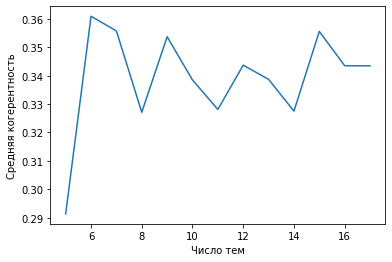

In [97]:
plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [104]:
topics_number = topics_list[coherences.index(max(coherences))]
topics_number

6

In [105]:
topics_number = coherences.index(max(coherences))
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=topics_number, chunksize=30, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.update_eta(self.state.get_lambda(), rho)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(

AssertionError: ignored